# Аугментация

In [18]:
import albumentations as alb
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def gen_aug(index, sub_index):
    img = cv2.imread(f'input\img\image{index}.jpg')
    mask = cv2.imread(f'input\mask\mask{index}.jpg')
    
    # Создание объекта аугментации
    transform = alb.Compose([
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Affine(translate_percent={"x": 0.1, "y": 0.1}, rotate=(-45, 45), scale=(0.8, 1.2), p=1.0),
        alb.RandomScale(scale_limit=0.1, p=0.5), 
        alb.RandomCrop(height=300, width=300, p=0.5), 
        alb.RandomBrightnessContrast(p=0.4),
        alb.Blur(blur_limit=3, p=0.3),
    ])

    # Применение аугментации к изображению
    augmented_i = transform(image=img, mask=mask)
    # augmented_m = transform(image=mask)
    
    # Получение аугментированного изображения
    augmented_image = augmented_i['image']
    augmented_mask = augmented_i['mask']
    
    resized_image = cv2.resize(augmented_image, (300, 300))
    resized_mask = cv2.resize(augmented_mask, (300, 300))

    # Сохранение аугментированного изображения
    cv2.imwrite(f'augment/img/augmented_image_{index}_{sub_index}.jpg', resized_image)
    cv2.imwrite(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', resized_mask)

In [20]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [21]:
count_aug = 10
for i in range(2):
    for num in range(count_aug):
        gen_aug(i, num)

# Машиночитаемый вид

In [22]:
import numpy as np

In [23]:
def get_machine_img(index, sub_index):    
    img = cv2.imread(f'augment/img/augmented_image_{index}_{sub_index}.jpg')
    mask = cv2.imread(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', cv2.IMREAD_GRAYSCALE)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, (300, 300))
    
    norm_img = img / 255.0
    # mask = cv2.resize(mask, (300, 300))
    norm_mask = (mask > 0).astype(np.float32) # бинаризация
    return (norm_img, norm_mask.reshape(300, 300, 1))
    

In [24]:
mass_img = []
mass_mask = [] 
for i in range(2):
    for num in range(count_aug):
        img, mask = get_machine_img(i, num)
        print(i, num, img.shape, mask.shape)
        mass_img.append(img), mass_mask.append(mask)
mass_img = np.array(mass_img)
mass_mask = np.array(mass_mask) 

0 0 (300, 300, 3) (300, 300, 1)
0 1 (300, 300, 3) (300, 300, 1)
0 2 (300, 300, 3) (300, 300, 1)
0 3 (300, 300, 3) (300, 300, 1)
0 4 (300, 300, 3) (300, 300, 1)
0 5 (300, 300, 3) (300, 300, 1)
0 6 (300, 300, 3) (300, 300, 1)
0 7 (300, 300, 3) (300, 300, 1)
0 8 (300, 300, 3) (300, 300, 1)
0 9 (300, 300, 3) (300, 300, 1)
1 0 (300, 300, 3) (300, 300, 1)
1 1 (300, 300, 3) (300, 300, 1)
1 2 (300, 300, 3) (300, 300, 1)
1 3 (300, 300, 3) (300, 300, 1)
1 4 (300, 300, 3) (300, 300, 1)
1 5 (300, 300, 3) (300, 300, 1)
1 6 (300, 300, 3) (300, 300, 1)
1 7 (300, 300, 3) (300, 300, 1)
1 8 (300, 300, 3) (300, 300, 1)
1 9 (300, 300, 3) (300, 300, 1)


# Создание модели

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Полносвязная нейронная сеть

1. **Полносвязаня нейронная сеть** - Базовая многослойная нейронка.
Между каждым нейроном между двумя ближайшими слоями есть связь, обладающая каким-то весом.
У каждого слоя есть *"функция активации"* - функция, взаимодействующая со значением.
Тренировка происходит с помощью градиентного спуска.

In [26]:
from tensorflow import keras

In [27]:
mass_img[0].shape, mass_mask[0].shape

((300, 300, 3), (300, 300, 1))

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x_t, x_v, y_t, y_v = train_test_split(mass_img, mass_mask, test_size=0.25, random_state=42)

In [30]:
x_t.shape

(15, 300, 300, 3)

In [31]:
# Создаем модель
model = keras.Sequential([
    # keras.layers.Input(shape=(x_t[0].shape)),
    keras.layers.Flatten(input_shape=(300, 300, 3)),
    keras.layers.Dense(1200, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(300 * 300, activation='sigmoid'),
    keras.layers.Reshape((300, 300, 1))
])

In [32]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision'])

In [33]:
# Обучаем модель
hst = model.fit(x=x_t, y=y_t, validation_data=(x_v, y_v), epochs=20, batch_size=15)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5008 - loss: 0.6934 - precision: 0.7041 - val_accuracy: 0.6133 - val_loss: 0.6769 - val_precision: 0.7290
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6176 - loss: 0.6661 - precision: 0.7650 - val_accuracy: 0.7272 - val_loss: 0.8209 - val_precision: 0.7722
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7415 - loss: 0.6614 - precision: 0.8094 - val_accuracy: 0.7290 - val_loss: 0.5116 - val_precision: 0.7713
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7503 - loss: 0.4969 - precision: 0.8109 - val_accuracy: 0.7633 - val_loss: 0.4882 - val_precision: 0.8046
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7916 - loss: 0.4382 - precision: 0.8470 - val_accuracy: 0.8213 - val_loss: 0.3779 - val_precision: 0.8696
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8565 - loss: 0.3511 - precision: 0.8980 - val_accuracy: 0.8481 - val_loss: 0.3549 - val_precision: 0.8

In [34]:
model.predict(x_v)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


array([[[[2.62766120e-09],
         [1.18628796e-09],
         [5.68449142e-11],
         ...,
         [1.59703882e-06],
         [5.92705373e-06],
         [6.70581869e-07]],

        [[1.43824570e-08],
         [4.09417877e-09],
         [1.05329456e-09],
         ...,
         [2.55481064e-06],
         [7.14279304e-05],
         [1.74270406e-06]],

        [[6.64708262e-12],
         [5.84500559e-10],
         [1.31710805e-11],
         ...,
         [1.14195905e-06],
         [2.59193371e-06],
         [5.63280017e-04]],

        ...,

        [[7.20330689e-16],
         [2.32159449e-16],
         [7.60718966e-17],
         ...,
         [2.78083200e-04],
         [3.55614088e-02],
         [1.97376103e-05]],

        [[2.05467090e-15],
         [1.23918525e-16],
         [6.87001001e-16],
         ...,
         [1.25154780e-04],
         [7.19897580e-05],
         [5.62268135e-04]],

        [[4.29447271e-15],
         [4.20753849e-16],
         [6.41778653e-16],
         ...,
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


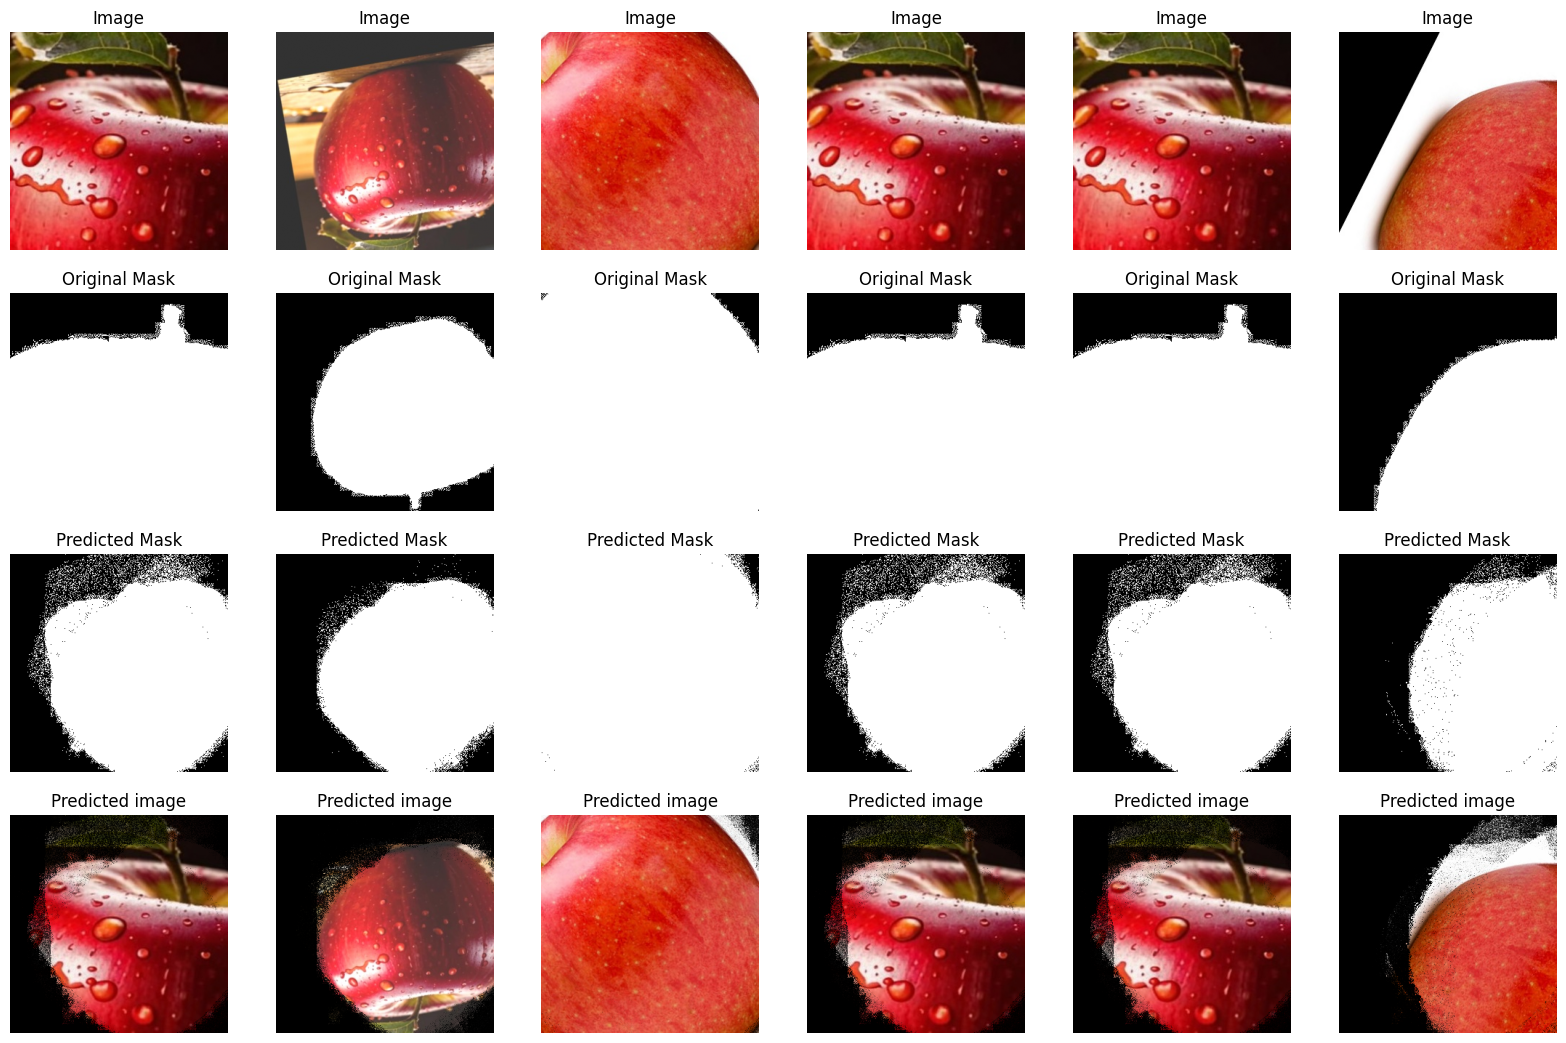

In [35]:
plot_results(x_v, y_v, model.predict(x_v), 2 * 3)

In [36]:
def plot_hist(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности (accur)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # График точности (prec)
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision during training')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.show()


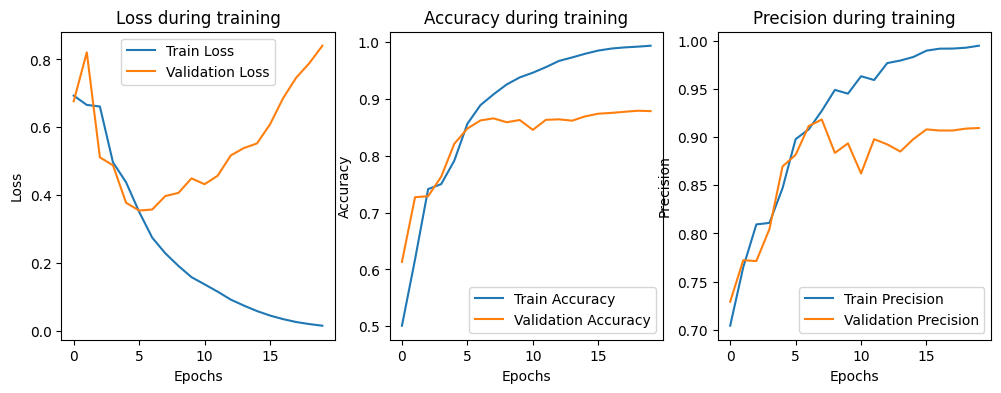

In [37]:
plot_hist(hst)

## U-net

2. **U-net** - Архитектура нейросети, созданная для сегментации изображений
Состоит из кодировщика и декодировщика
    1. *Кодировщик* - Состоит из свёрточных слоёв, позволяющих искать нужные признаки.
    2. *Декодировщик* - Состоит из транспонированных свёрточных слоёв, разворачивающих изображение и уменьшающих кол-во фильтров.

In [39]:
base_model = keras.applications.MobileNetV2(input_shape=(300, 300, 3), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

# up_stack = [
#     pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#     pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#     pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#     pix2pix.upsample(64, 3),   # 32x32 -> 64x64
# ]

C:\Users\artem\AppData\Local\Temp\ipykernel_62556\1908153074.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(input_shape=(300, 300, 3), include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [40]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[300, 300, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
#   for up, skip in zip(up_stack, skips):
#     x = up(x)
#     concat = tf.keras.layers.Concatenate()
#     x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
model_u = unet_model(3)
model_u.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
hst_u = model_u.fit(x=x_t, y=y_t, validation_data=(x_v, y_v), epochs=40, batch_size=15)

Epoch 1/40


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(15, 300, 300), output.shape=(15, 20, 20, 3)

In [ ]:
plot_hist(hst_u)